<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Rapid Application Development<br>using Large Language Models</b></h1>
<h2><b>Notebook 8:</b> Course Assessment</h2>
<br>

**Congratulations On (Almost) Finishing The Course!** 

We hope you've enjoyed the journey and have gained valuable skills to get starting with building novel and interesting language-guided applications. Now, it's time to put those skills to the test for an assessment! In previous sections, we've explored various aspects of language models, including data pipelining tools, visual language models (VLMs), and diffusion models. An assessment prep notebook is also available (see notebook 7.5) which can help with this exercise! In this assessment, we'll bring all these concepts together to build an interesting application that you likely take for granted if you've ever used an image generator.

### **Setup**

Before we begin, let's set up our environment by importing the necessary libraries and initializing our language model.

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

model_path = "http://0.0.0.0:9004/v1"
%env NVIDIA_BASE_URL=$model_path
%env NVIDIA_DEFAULT_MODE=open

model_name = "meta/llama-3.3-70b-instruct"

## Maybe you'll need more connectors? Maybe you'll need a different endpoint (this one may be down)? 
llm = ChatNVIDIA(
    model=model_name, 
    base_url=model_path, 
    max_tokens=5000, 
    temperature=0
)

env: NVIDIA_BASE_URL=http://0.0.0.0:9004/v1
env: NVIDIA_DEFAULT_MODE=open


<hr>
<br>

## **Part 8.1:** Assessment

For the course assessment, you will be implementing a common feature that usually sits behind the API of an image-generating endpoint; **synthetic prompts**.

When creating text-conditioned diffusion models, developers usually create synthetic keyword-rich datasets for training that allow the model to learn strong customization priors. 
- **In an ideal scenario,** an image generator could be prompted to generate a truly-arbitrary high-quality image that perfectly fits any natural-language prompt - as long as the prompt itself is expressive enough.
- **In practice,** image generators are prompted - and sometimes trained - with loose directives and the model makes sprawling assumptions about the details based on its training data. This commonly manifests as "image retrieval," where training data with only minor modifications gets produced.

Most providers would be more interested in giving people the freedom to prompt the model however they want, so many choose to incorporate text-to-text interfaces that map from "regular human prompt" to "diffusion input prompt" space. 

### **Exercise:** Image-Inspired Generation

For the course exercise, you will implement a potential schema that combines synthetic prompts with vision to "create images inspired by another image." The process is broken down into tasks below, and will need to be incorporated at the end to pass the assessment. 

<div><img src="imgs/rad-assessment.png" width="800"/></div>

**NOTE:** Tasks 1 through 3 are merely building blocks to implement the final solution in Task 4. Only the results of Task 4 will be graded. Feel free to skip tasks 1 through 3 if you are confident that it will not necessary.

<hr>
<br>

### **[Task 1]** Image Ingestion

First off, we need to be able to take in and reason about an image. To do this, implement the `ask_about_image` method below:

**Simplifying Assumptions:**
- It shouldn't be too hard to have your LLM predict both a question and an image file, but feel free to hardcode the question instead.
- It's generally best to leverage some combination of batching, caching, grouping, and preprocessing depending on how frequently your image pool gets updated. Feel free to forego such optimizations.
- LangChain connectors like `ChatNVIDIA` and `ChatOpenAI` do actually provide a streamlined interface, but feel free to recycle the requests code from before. Whatever's easiest.

**HINTS:**
- Recall your learnings from the VLM spinup in notebook 6. Perhaps we could use that model? Is it still up?
- More of a note, but some models like GPT-4o are extremely strong as both chat and image-reasoning models.
- If you run out of cuda memory, it sounds like you might be over-allocating something. Try restarting your kernels. 

In [8]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_nvidia import ChatNVIDIA

def image_to_text_placeholder(image_path: str) -> str:
    return f"[Image {image_path} attached]"

def notebook_to_markdown(filename):
    with open(filename, 'r') as f:
        content = f.read()
        return content[:1000]  

filenames = [v for v in sorted(os.listdir(".")) if v.endswith(".ipynb")]
context_files = ["06_llm_server.ipynb"]

full_context = "\n\n".join(
    f"\n[[[{filename}]]]\n\n{notebook_to_markdown(filename)}" for filename in context_files
)

model_name = "meta/llama-3.1-70b-instruct"
llm = ChatNVIDIA(model=model_name, max_tokens=4096)  

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", (
        "You are a helpful DLI Chatbot who can reason about both text and images."
        " If the user provides an image description, treat it as part of the input context."
    )),
    ("human", "Here is the notebook I want you to work with: {full_context}. Remembering this, start the conversation over."),
    ("ai", "Awesome! I will work with this as context and will restart the conversation."),
    ("placeholder", "{messages}")
])

pipeline = chat_prompt | llm | StrOutputParser()

image_path = "imgs/agent-overview.png"
image_description = image_to_text_placeholder(image_path)

state = {
    "filenames": filenames,
    "context_files": context_files, 
    "full_context": full_context,
    "messages": [
        ("human", f"Here's an image I want you to reason about: {image_description}. Can you describe it?")
    ]
}

description = ""
for chunk in pipeline.stream(state):
    print(chunk, end="", flush=True)
    description += chunk

print("\n\n[Final Description]:", description)



Based on the image description, I'll try to paint a verbal picture of the image.

The image appears to be a diagram or an overview of a system architecture. It might be related to the topic of Large Language Models and Rapid Application Development, given the context of the notebook.

Here's a possible description of the image:

The image shows a high-level overview of an agent or a system, possibly a GenAI server, given the notebook's title. The diagram likely consists of several interconnected components or modules, represented by rectangles, arrows, or other shapes.

There might be labels or text annotations on the image, highlighting specific parts of the system, such as input/output interfaces, processing units, or data storage components. The overall structure of the image could be conveying the flow of information, data processing, or decision-making within the system.

If you'd like to provide more context or clarify any specific aspects of the image, I'd be happy to try and pr

<hr>
<br>

### **[Task 2]** Image Creation

Now that we have our image descriptions, let's try to generate an image based on this response:

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["agent or a system , possibly a genai server , given the notebook 's title . the diagram likely consists of several interconnected components or modules , represented by rectangles , arrows , or other shapes . there might be labels or text annotations on the image , highlighting specific parts of the system , such as input / output interfaces , processing units , or data storage components . the overall structure of the image could be conveying the flow of information , data processing , or decision - making within the system . if you 'd like to provide more context or clarify any specific aspects of the image , i 'd be happy to try and provide a more detailed description !"]


  0%|          | 0/50 [00:00<?, ?it/s]

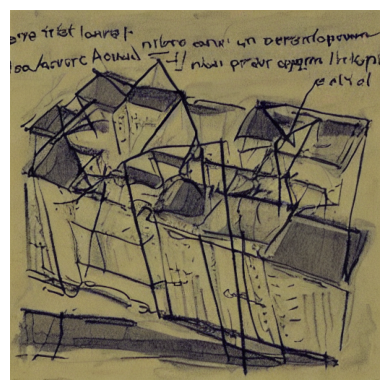

In [9]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import uuid
import os

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

def generate_images(prompt: str, n: int = 1):
    images = []
    for i in range(n):
        result = pipe(prompt).images[0]
        filename = f"generated_{uuid.uuid4().hex[:8]}.png"
        result.save(filename)
        images.append(filename)
    return images

def plot_imgs(image_paths, r=2, c=2):
    fig, axes = plt.subplots(r, c, figsize=(4*c, 4*r))
    for i, ax in enumerate(getattr(axes, "flat", [axes])):
        if i < len(image_paths):
            img = plt.imread(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')  
    plt.tight_layout()
    plt.show()

images = generate_images(description, n=1)
plot_imgs(images, r=1, c=1)


<hr>
<br>

### **[Task 3]** Prompt Synthesis

After an initial attempt, you should notice that this type of description is far too complex. Perhaps we can get better results if we connect these two disparate components with an LLM-enabled interface?

In the abstract, this interface is helping to map from the VLM output domain to the Diffusion input domain, but could have been done between just about any two function specifications. **In more simple terms, we're trying to map from VLM description to Diffusion prompt using an intermediate step.**

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_nvidia import ChatNVIDIA
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import uuid

# Initialize diffusion pipeline (Stable Diffusion)
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

def generate_images(prompt: str, n: int = 1):
    images = []
    for i in range(n):
        result = pipe(prompt).images[0]
        filename = f"generated_{uuid.uuid4().hex[:8]}.png"
        result.save(filename)
        images.append(filename)
    return images

def plot_imgs(image_paths, r=2, c=2):
    fig, axes = plt.subplots(r, c, figsize=(4*c, 4*r))
    for i, ax in enumerate(getattr(axes, "flat", [axes])):
        if i < len(image_paths):
            img = plt.imread(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')  # turn off extra plots
    plt.tight_layout()
    plt.show()

def llm_rewrite_to_image_prompts(user_query: str, n: int = 4) -> list[str]:
    model_name = "meta/llama-3.1-70b-instruct"
    llm = ChatNVIDIA(model=model_name, max_tokens=2048)

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", (
            "You are an expert prompt engineer. Rewrite the following detailed description "
            f"into {n} short, vivid, high-quality prompts suitable for Stable Diffusion image generation. "
            "Make sure they are imaginative and focused on visual details."
        )),
        ("human", "{user_query}")
    ])

    pipeline = prompt_template | llm | StrOutputParser()

    rewritten = pipeline.invoke({"user_query": user_query})

    sd_prompts = [line.strip() for line in rewritten.split("\n") if line.strip()]

    if len(sd_prompts) > n:
        sd_prompts = sd_prompts[:n]
    elif len(sd_prompts) < n:
        sd_prompts += ["(missing prompt)"] * (n - len(sd_prompts))

    assert len(sd_prompts) == n
    return sd_prompts

# Example VLM description (replace with Task 1 output if available)
description = "A futuristic cityscape at sunset with flying cars, neon lights, and holographic billboards."

# Get rewritten prompts
new_sd_prompts = llm_rewrite_to_image_prompts(description)

print("\n[Generated Stable Diffusion Prompts]:")
for i, p in enumerate(new_sd_prompts, 1):
    print(f"{i}. {p}")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


[Generated Stable Diffusion Prompts]:
1. Here are 4 short, vivid, high-quality prompts suitable for Stable Diffusion image generation:
2. **1.** "Dusk descends on a neon metropolis: sweeping skyscrapers, flying cars zip past, as holographic ads swirl like auroras."
3. **2.** "Holographic skyscrapers ablaze with color, flying vehicles pierce the smoldering sunset, casting a warm glow on the city's steel canyons."
4. **3.** "Urban utopia at sunset: iridescent billboards orbit towering spires, while flying cars weave through the misty, golden light."


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

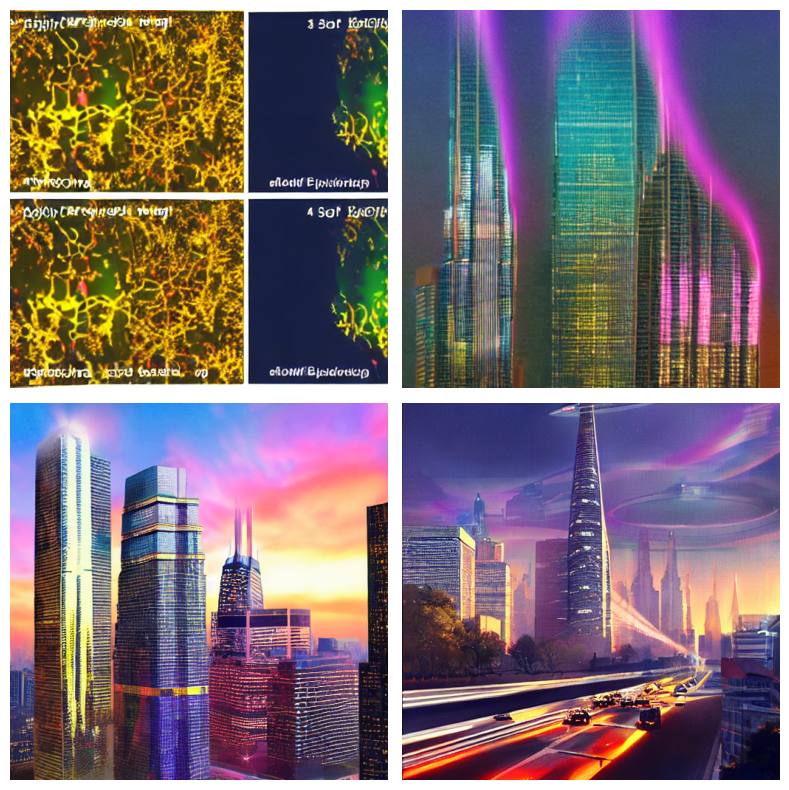

In [11]:
images = [generate_images(sd_prompt)[0] for sd_prompt in new_sd_prompts]
plot_imgs(images)

<hr>
<br>

### **[Task 4]** Pipelining and Iterating

**To finish the assessment, incorporate these tasks into a pipeline to make the following process turn-key:**
- **Take in an image from the compute environment.**
- **Compute a summary of the image.**
- **Use an LLM to create four different synthetic prompts for the image generation pipeline.**
- **Produce four destinct images that you are happy with.**

**NOTES:**
- Feel free to implement it as either a standard function or a chain.
- Return an array of PIL Images. You can optionally display them by default.
- To speed up the process, we recommend trying out parallel processes and batching. 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


Generating images for: imgs/agent-overview.png
[Image Description]: a block diagram with the block diagram and block diagram
[Generated Prompts]:
1. It seems like the original text is a bit repetitive! Here are 4 distinct, short prompts for Stable Diffusion image generation based on your text:
2. 1. **Simple Block Diagram**: Generate a basic block diagram with 4-6 blocks and simple connections between them.
3. 2. **Detailed Circuit Block Diagram**: Create a more detailed block diagram of an electronic circuit with numerous blocks, wires, and connectors.
4. 3. **Abstract Block Diagram**: Produce a stylized block diagram with a futuristic aesthetic, featuring glowing blocks and neon-lit connections.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

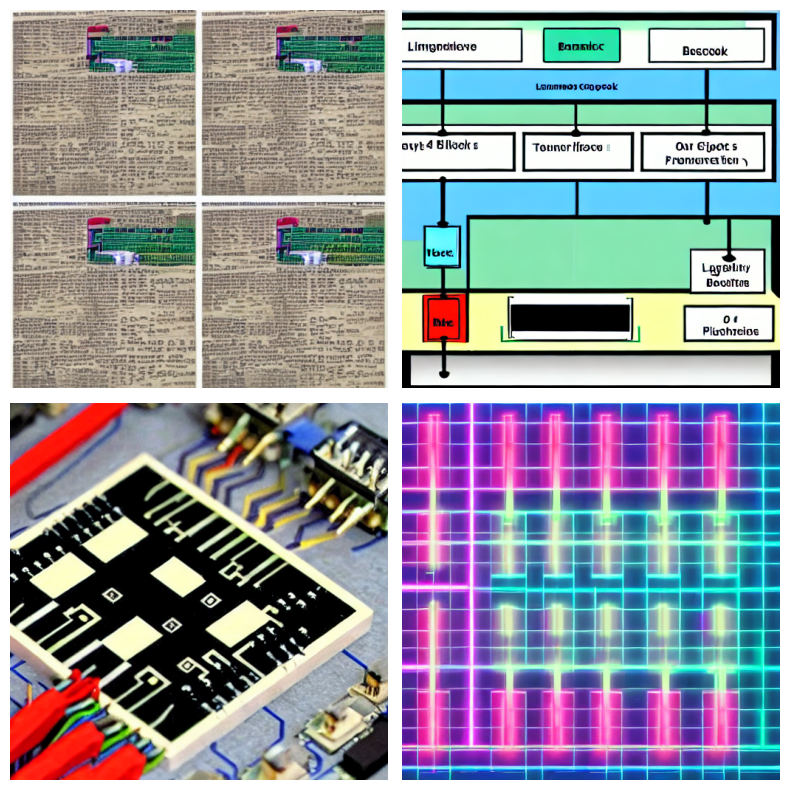


Generating images for: imgs/multimodal.png
[Image Description]: a diagram of the different types of the internet
[Generated Prompts]:
1. Here are 4 distinct, short prompts suitable for Stable Diffusion image generation based on the original image description:
2. **1.** "Network topology illustration with various internet types connected"
3. **2.** "Infographic showcasing categories of the internet, including dark web, deep web, and surface web"
4. **3.** " Diagram of internet layers, including network protocols, infrastructure, and services"


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

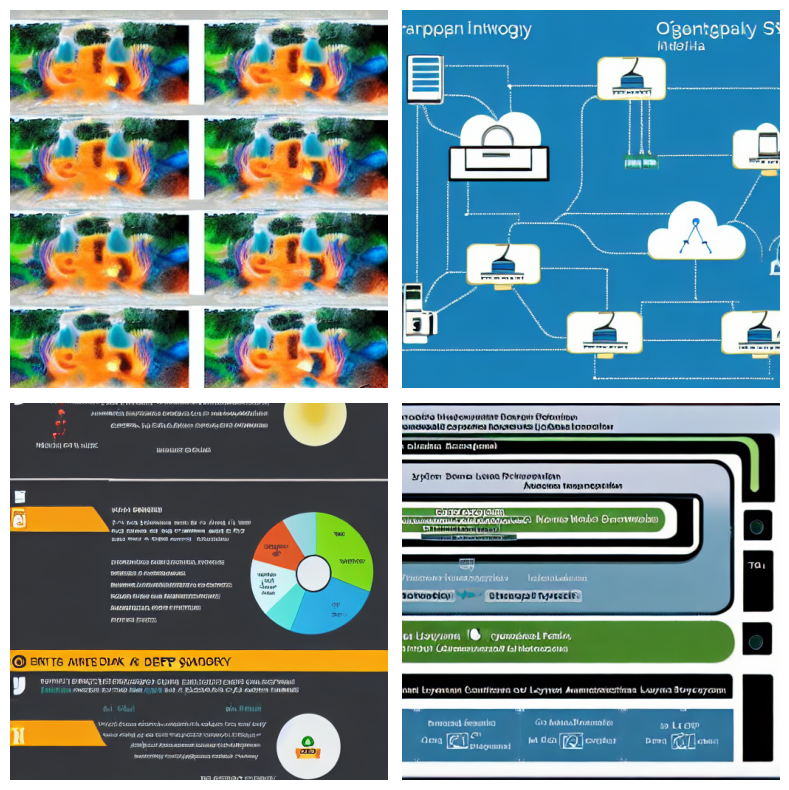


Generating images for: img-files/tree-frog.jpg
[Image Description]: a frog sitting on a leaf with water droplets
[Generated Prompts]:
1. Here are 4 distinct, short prompts suitable for Stable Diffusion image generation:
2. 1. "Close-up of a bright green frog perched on a large leaf, surrounded by glistening water droplets"
3. 2. "Amphibian on a lily pad: frog sitting calmly on a leaf, water droplets scattered around its feet"
4. 3. "Rain-kissed frog: a small frog resting on a leaf, water droplets clinging to its skin and the leaf's surface"


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

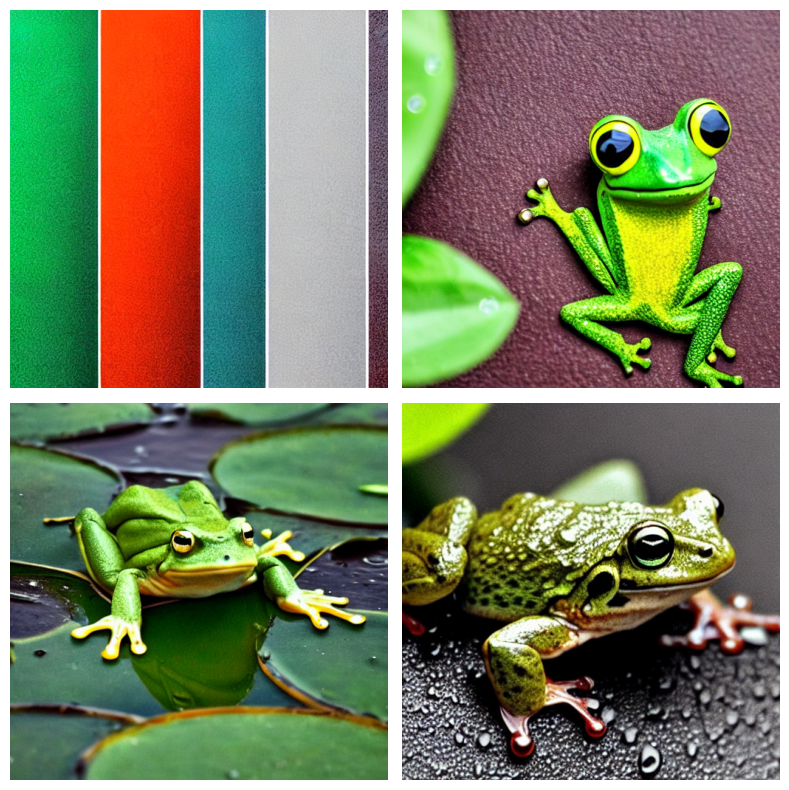


Generating images for: img-files/paint-cat.jpg
[Image Description]: a cat with a rainbow colored mane on its head
[Generated Prompts]:
1. Here are 4 distinct, short prompts suitable for Stable Diffusion image generation:
2. 1. "Regal cat with rainbow-colored fur on its head"
3. 2. "Feline with vibrant, multicolored mane"
4. 3. "Cat with colorful, iridescent fur tuft on its head"


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

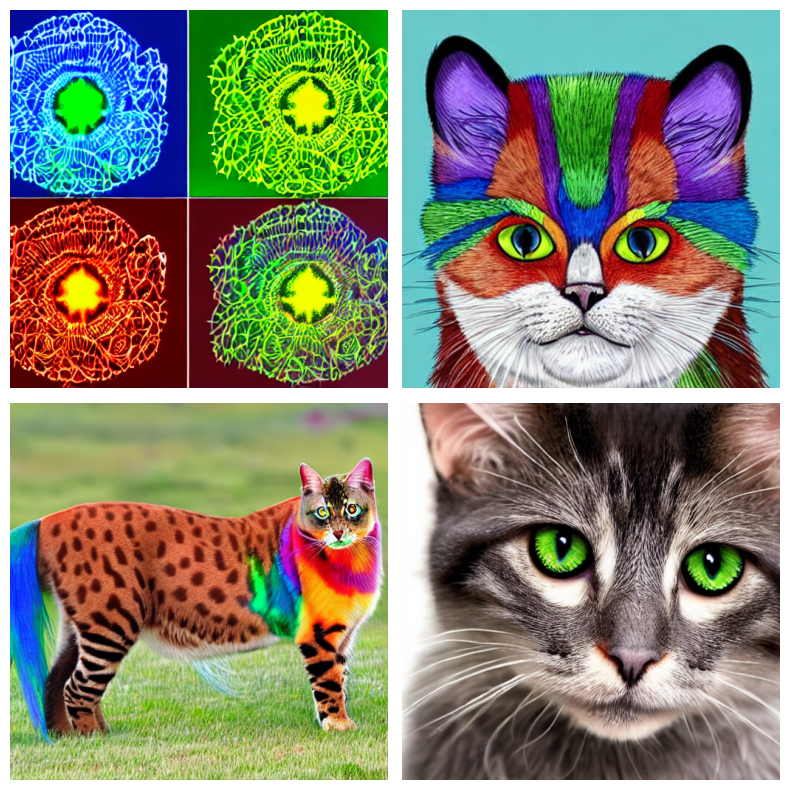

In [15]:
import os
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_nvidia import ChatNVIDIA
from diffusers import DiffusionPipeline
import matplotlib.pyplot as plt
import uuid

# Ensure save directory exists
SAVE_DIR = "generated_images"
os.makedirs(SAVE_DIR, exist_ok=True)

# Initialize BLIP model once
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Initialize Diffusion pipeline once
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Optional: Plotting
def plot_imgs(pil_images, r=2, c=2):
    fig, axes = plt.subplots(r, c, figsize=(4 * c, 4 * r))
    for i, ax in enumerate(getattr(axes, "flat", [axes])):
        if i < len(pil_images):
            ax.imshow(pil_images[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Core pipeline function
def generate_images_from_image(image_path: str, num_images=4):
    print(f"\nGenerating images for: {image_path}")

    # Step 1: Get BLIP description
    raw_image = Image.open(image_path).convert('RGB')
    inputs = blip_processor(raw_image, return_tensors="pt")
    out = blip_model.generate(**inputs)
    original_description = blip_processor.decode(out[0], skip_special_tokens=True)
    print(f"[Image Description]: {original_description}")

    # Step 2: Rewrite to prompts
    model_name = "meta/llama-3.1-70b-instruct"
    llm = ChatNVIDIA(model=model_name, max_tokens=2048)
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", (
            f"Rewrite the following image description into {num_images} distinct, short prompts "
            f"suitable for Stable Diffusion image generation."
        )),
        ("human", "{user_query}")
    ])
    pipeline = prompt_template | llm | StrOutputParser()
    rewritten = pipeline.invoke({"user_query": original_description})
    diffusion_prompts = [line.strip() for line in rewritten.split("\n") if line.strip()]

    if len(diffusion_prompts) > num_images:
        diffusion_prompts = diffusion_prompts[:num_images]
    elif len(diffusion_prompts) < num_images:
        diffusion_prompts += ["(missing prompt)"] * (num_images - len(diffusion_prompts))

    print("[Generated Prompts]:")
    for i, p in enumerate(diffusion_prompts, 1):
        print(f"{i}. {p}")

    # Step 3: Generate images and save file paths
    saved_image_paths = []
    for i, prompt in enumerate(diffusion_prompts):
        img = pipe(prompt).images[0]
        filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_{i}_{uuid.uuid4().hex[:8]}.png"
        save_path = os.path.join(SAVE_DIR, filename)
        img.save(save_path)
        saved_image_paths.append(save_path)

    # Optional: Display images
    loaded_images = [Image.open(p) for p in saved_image_paths]
    plot_imgs(loaded_images, r=2, c=2)

    # Return file paths, prompts, description (aligned for assessment)
    return saved_image_paths, diffusion_prompts, original_description

# Run pipeline on required images
results = []
results.append(generate_images_from_image("imgs/agent-overview.png"))
results.append(generate_images_from_image("imgs/multimodal.png"))
results.append(generate_images_from_image("img-files/tree-frog.jpg"))
results.append(generate_images_from_image("img-files/paint-cat.jpg"))



<hr>
<br>

## **Part 8.2:** Running The Assessment

To assess your submission, run the following cells to save your results and the one after to query the assessment runner.

**Follow the instructions and make sure it all passes.**

In [16]:
import os
import json
import requests
from PIL import Image
import re

def send_metadata(results):    
    
    save_dir="generated_images"
    
    # Collect all image paths and metadata
    all_metadata = []

    for result in results:
        image_paths, prompts, original_description = result
        
        # Append metadata for the current batch
        all_metadata.append({
            "original_description": original_description,
            "prompts": prompts,
            "image_paths": [path.replace("/dli/task/", "") for path in image_paths]
        })
    
    # Save all metadata in a single JSON file
    metadata_path = os.path.join(save_dir, "all_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(all_metadata, f, indent=4)
    return all_metadata

## Generate your submission
submission = send_metadata(results)

## Send the submission over to the assessment runner
response = requests.post(
    "http://docker_router:8070/run_assessment", 
    json={"submission": submission},
)

response.raise_for_status()

try: 
    print(response.json().get("result") or "<No Results>")
    print(response.json().get("messages") or "<No More Messages>")
    print(response.json().get("exceptions") or "<No Exceptions>")
except:
    print(response.__dict__)

Congratulations! You passed the assessment!
See instructions below to generate a certificate.
<No More Messages>
<No Exceptions>


<br>

If you passed the assessment, please return to the course page (shown below) and click the **"ASSESS TASK"** button, which will generate your certificate for the course.

<img src="./imgs/assess_task.png" style="width: 800px;">


<hr>
<br>

## **Part 8.3:** Wrapping Up

### <font color="#76b900">**Congratulations On Completing The Course!!**</font>

Before concluding the course, we highly recommend downloading the course material for later reference, and checking over the **"Next Steps"** and **Feedback** sections of the course. **We appreciate you taking the time to go through the course, and look forward to seeing you again for the next courses in the series!**

<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>